## 문제 정의
- 환자의 데이터를 입력으로 하여 갑상선 질환 여부를 분류하는 이진 분류 문제
    - 평가지표: F1-score
- 컴피티션 주소
    - https://www.kaggle.com/competitions/scu-ai-competition-202401



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 컴피티션 데이터 다운로드 및 압축 풀기

In [3]:
# !gdown 1IOgB_HQs0BrXsD4DssDnHAlsmtmWCEN7 # 데이터 압축 파일 다운로드
# !unzip -oqq scu-ai-competition-202401.zip # 압축 풀기

- 데이터 경로 변수


In [4]:
DATA_PATH = "/content/drive/MyDrive/scu-ai-competition-202401/"
DATA_PATH

'/content/drive/MyDrive/scu-ai-competition-202401/'

- 시드값

In [5]:
SEED = 42

- 데이터 불러오기

In [6]:
import pandas as pd
import numpy as np

train = pd.read_csv(f"{DATA_PATH}train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}test.csv") # 테스트 데이터
train.shape , test.shape

((4223, 18), (3456, 17))

# 타겟 컬럼
- 0: 정상 환자
- 1: 갑상선 질환 환자

In [7]:
train.head()

,ID,나이,성별,티록신_복용_여부,항갑상선제_복용_여부,지병_여부,임신_여부,갑상선_수술_이력,I131_치료_여부,갑상선저하_인지_여부,갑상선항진증_인지_여부,리튬_치료_여부,갑상선종_여부,종양_여부,TSH,FreeT3,FreeT4,target
0,train_0,59.0,남,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,NaN,NaN,0.77,0
1,train_1,63.0,남,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,33.0,1.5,NaN,1
2,train_2,65.0,여,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,1.7,2.3,0.95,0
3,train_3,33.0,남,아니오,아니오,예,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,6.2,NaN,0.66,0
4,train_4,64.0,여,예,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,1.2,NaN,0.95,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4223 entries, 0 to 4222
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            4223 non-null   object 
 1   나이            4220 non-null   float64
 2   성별            4086 non-null   object 
 3   티록신_복용_여부     4223 non-null   object 
 4   항갑상선제_복용_여부   4223 non-null   object 
 5   지병_여부         4223 non-null   object 
 6   임신_여부         4223 non-null   object 
 7   갑상선_수술_이력     4223 non-null   object 
 8   I131_치료_여부    4223 non-null   object 
 9   갑상선저하_인지_여부   4223 non-null   object 
 10  갑상선항진증_인지_여부  4223 non-null   object 
 11  리튬_치료_여부      4223 non-null   object 
 12  갑상선종_여부       4223 non-null   object 
 13  종양_여부         4223 non-null   object 
 14  TSH           3832 non-null   float64
 15  FreeT3        2989 non-null   float64
 16  FreeT4        3854 non-null   float64
 17  target        4223 non-null   int64  
dtypes: float64(4), int64(1), obj

# 타겟값 확인
- 비율 확인하기

In [9]:
train["target"].mean()

0.11816244376035993

# 결측치 처리

In [10]:
train.isnull().sum()

ID                 0
나이                 3
성별               137
티록신_복용_여부          0
항갑상선제_복용_여부        0
지병_여부              0
임신_여부              0
갑상선_수술_이력          0
I131_치료_여부         0
갑상선저하_인지_여부        0
갑상선항진증_인지_여부       0
리튬_치료_여부           0
갑상선종_여부            0
종양_여부              0
TSH              391
FreeT3          1234
FreeT4           369
target             0
dtype: int64

In [11]:
test.isnull().sum()

ID                0
나이                1
성별              117
티록신_복용_여부         0
항갑상선제_복용_여부       0
지병_여부             0
임신_여부             0
갑상선_수술_이력         0
I131_치료_여부        0
갑상선저하_인지_여부       0
갑상선항진증_인지_여부      0
리튬_치료_여부          0
갑상선종_여부           0
종양_여부             0
TSH             333
FreeT3          975
FreeT4          312
dtype: int64

- Data leakage를 피하기 위해 임의로 정한 상수 또는 학습데이터의 통계치를 이용하여 결측치를 처리해야 한다.

In [12]:
fill_age = train["나이"].median()
fill_tsh = train["TSH"].median()
fill_free_t3 = train["FreeT3"].median()
fill_free_t4 = train["FreeT4"].median()

In [13]:
train["나이"] = train["나이"].fillna(fill_age)
train["성별"] = train["성별"].fillna("UNK")
train["TSH"] = train["TSH"].fillna(fill_tsh)
train["FreeT3"] = train["FreeT3"].fillna(fill_free_t3)
train["FreeT4"] = train["FreeT4"].fillna(fill_free_t4)

In [14]:
test["나이"] = test["나이"].fillna(fill_age)
test["성별"] = test["성별"].fillna("UNK")
test["TSH"] = test["TSH"].fillna(fill_tsh)
test["FreeT3"] = test["FreeT3"].fillna(fill_free_t3)
test["FreeT4"] = test["FreeT4"].fillna(fill_free_t4)

In [15]:
train.isnull().sum().sum() , test.isnull().sum().sum()

(0, 0)

In [16]:
train.columns

Index(['ID', '나이', '성별', '티록신_복용_여부', '항갑상선제_복용_여부', '지병_여부', '임신_여부',
       '갑상선_수술_이력', 'I131_치료_여부', '갑상선저하_인지_여부', '갑상선항진증_인지_여부', '리튬_치료_여부',
       '갑상선종_여부', '종양_여부', 'TSH', 'FreeT3', 'FreeT4', 'target'],
      dtype='object')

# 특성 공학(Feature Engineering)
- Feature Engineering 과정에서 평가를 위한 예측을 해야하기 때문에 테스트 세트에 대해서도 동일한 작업을 진행해줘야 한다.


## "예" 또는 "아니오" 값만 갖고 있는 컬럼들 이진변수로 변경
- 두개의 값들만 존재하는 범주형 변수에 경우 원핫 인코딩처리할 경우 불필요한 피처가 추가된다.
- 예를 1로, 아니오를 0으로 변경 처리

In [17]:
cols = [ col for col in train.columns if col.endswith("여부") or col.endswith("이력") ]
cols

['티록신_복용_여부',
 '항갑상선제_복용_여부',
 '지병_여부',
 '임신_여부',
 '갑상선_수술_이력',
 'I131_치료_여부',
 '갑상선저하_인지_여부',
 '갑상선항진증_인지_여부',
 '리튬_치료_여부',
 '갑상선종_여부',
 '종양_여부']

In [18]:
train[cols] = (train[cols] == "예").astype(int)
test[cols] = (test[cols] == "예").astype(int)

In [19]:
train.head()

,ID,나이,성별,티록신_복용_여부,항갑상선제_복용_여부,지병_여부,임신_여부,갑상선_수술_이력,I131_치료_여부,갑상선저하_인지_여부,갑상선항진증_인지_여부,리튬_치료_여부,갑상선종_여부,종양_여부,TSH,FreeT3,FreeT4,target
0,train_0,59.0,남,0,0,0,0,0,0,0,0,0,0,0,1.4,2.0,0.77,0
1,train_1,63.0,남,0,0,0,0,0,0,0,0,0,0,0,33.0,1.5,0.96,1
2,train_2,65.0,여,0,0,0,0,0,0,0,0,0,0,0,1.7,2.3,0.95,0
3,train_3,33.0,남,0,0,1,0,0,0,0,0,0,0,0,6.2,2.0,0.66,0
4,train_4,64.0,여,1,0,0,0,0,0,0,0,0,0,0,1.2,2.0,0.95,0


## Feature Extraction

- 특성으로 사용할 변수 추가하기

In [20]:
train_ft = train.iloc[:,1:-1].copy() # ID 컬럼 및 정답 컬럼 제외
test_ft = test.iloc[:,1:].copy() # ID 컬럼 제외
train_ft.shape, test_ft.shape

((4223, 16), (3456, 16))

In [21]:
train_ft.columns

Index(['나이', '성별', '티록신_복용_여부', '항갑상선제_복용_여부', '지병_여부', '임신_여부', '갑상선_수술_이력',
       'I131_치료_여부', '갑상선저하_인지_여부', '갑상선항진증_인지_여부', '리튬_치료_여부', '갑상선종_여부',
       '종양_여부', 'TSH', 'FreeT3', 'FreeT4'],
      dtype='object')

### 여부 및 이력 관련 컬럼들의 예(1)의 합계를 피처로 추가

In [22]:
train_ft

,나이,성별,티록신_복용_여부,항갑상선제_복용_여부,지병_여부,임신_여부,갑상선_수술_이력,I131_치료_여부,갑상선저하_인지_여부,갑상선항진증_인지_여부,리튬_치료_여부,갑상선종_여부,종양_여부,TSH,FreeT3,FreeT4
0,59.0,남,0,0,0,0,0,0,0,0,0,0,0,1.40,2.0,0.77
1,63.0,남,0,0,0,0,0,0,0,0,0,0,0,33.00,1.5,0.96
2,65.0,여,0,0,0,0,0,0,0,0,0,0,0,1.70,2.3,0.95
3,33.0,남,0,0,1,0,0,0,0,0,0,0,0,6.20,2.0,0.66
4,64.0,여,1,0,0,0,0,0,0,0,0,0,0,1.20,2.0,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4218,74.0,남,0,0,0,0,0,0,0,0,0,0,0,2.70,1.7,1.11
4219,38.0,남,0,0,0,0,0,0,0,0,0,0,0,2.00,2.6,0.85
4220,44.0,여,0,0,0,0,0,0,0,0,0,0,0,0.30,1.5,1.07
4221,73.0,남,0,0,0,0,0,0,0,0,0,0,0,3.90,1.9,0.80


In [23]:
cols = [ col for col in train_ft.columns if col.endswith("여부") or col.endswith("이력") ]
train_ft["yes_sum"] = train_ft[cols].sum(axis=1)
test_ft["yes_sum"] = test_ft[cols].sum(axis=1)

### 여부 및 이력 관련 2개의 컬럼 조합의 예(1)의 합계를 피처로 추가

In [24]:
cols

['티록신_복용_여부',
 '항갑상선제_복용_여부',
 '지병_여부',
 '임신_여부',
 '갑상선_수술_이력',
 'I131_치료_여부',
 '갑상선저하_인지_여부',
 '갑상선항진증_인지_여부',
 '리튬_치료_여부',
 '갑상선종_여부',
 '종양_여부']

In [25]:
from itertools import combinations
for comb_cols in combinations(cols, 2):
    comb_cols = list(comb_cols)
    train_ft["_".join(comb_cols)] = train_ft[comb_cols].sum(axis=1)
    test_ft["_".join(comb_cols)] = test_ft[comb_cols].sum(axis=1)

### 여부 및 이력 관련 3개의 컬럼 조합의 예(1)의 합계를 피처로 추가

In [26]:
for comb_cols in combinations(cols, 3):
    comb_cols = list(comb_cols)
    train_ft["_".join(comb_cols)] = train_ft[comb_cols].sum(axis=1)
    test_ft["_".join(comb_cols)] = test_ft[comb_cols].sum(axis=1)

<ipython-input-26-d43560ac81a8>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_ft["_".join(comb_cols)] = train_ft[comb_cols].sum(axis=1)
<ipython-input-26-d43560ac81a8>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_ft["_".join(comb_cols)] = test_ft[comb_cols].sum(axis=1)
<ipython-input-26-d43560ac81a8>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

### FreeT4 / FreeT3 비를 피처로 추가

In [27]:
train_ft["FreeT4_FreeT3"] =  train_ft["FreeT4"] / train_ft["FreeT3"]
test_ft["FreeT4_FreeT3"] =   test_ft["FreeT4"] / test_ft["FreeT3"]

<ipython-input-27-b1c165af01ed>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_ft["FreeT4_FreeT3"] =  train_ft["FreeT4"] / train_ft["FreeT3"]
<ipython-input-27-b1c165af01ed>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_ft["FreeT4_FreeT3"] =   test_ft["FreeT4"] / test_ft["FreeT3"]


## Feature Encoding

- One-Hot Encoding

In [28]:
from sklearn.preprocessing import OneHotEncoder
cols = train_ft.select_dtypes("object").columns.tolist()
enc = OneHotEncoder(handle_unknown = 'ignore')
cols

['성별']

In [29]:
# 학습데이터
tmp = pd.DataFrame(
    enc.fit_transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols) # 범주형 컬럼 제거
train_ft.head()

,나이,티록신_복용_여부,항갑상선제_복용_여부,지병_여부,임신_여부,갑상선_수술_이력,I131_치료_여부,갑상선저하_인지_여부,갑상선항진증_인지_여부,리튬_치료_여부,...,갑상선저하_인지_여부_리튬_치료_여부_종양_여부,갑상선저하_인지_여부_갑상선종_여부_종양_여부,갑상선항진증_인지_여부_리튬_치료_여부_갑상선종_여부,갑상선항진증_인지_여부_리튬_치료_여부_종양_여부,갑상선항진증_인지_여부_갑상선종_여부_종양_여부,리튬_치료_여부_갑상선종_여부_종양_여부,FreeT4_FreeT3,성별_UNK,성별_남,성별_여
0,59.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.385000,0.0,1.0,0.0
1,63.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.640000,0.0,1.0,0.0
2,65.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.413043,0.0,0.0,1.0
3,33.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.330000,0.0,1.0,0.0
4,64.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.475000,0.0,0.0,1.0


In [30]:
# 테스트데이터
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(), # 테스트데이터는 transform 만 해야한다.
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols) # 범주형 컬럼 제거
test_ft.head()

,나이,티록신_복용_여부,항갑상선제_복용_여부,지병_여부,임신_여부,갑상선_수술_이력,I131_치료_여부,갑상선저하_인지_여부,갑상선항진증_인지_여부,리튬_치료_여부,...,갑상선저하_인지_여부_리튬_치료_여부_종양_여부,갑상선저하_인지_여부_갑상선종_여부_종양_여부,갑상선항진증_인지_여부_리튬_치료_여부_갑상선종_여부,갑상선항진증_인지_여부_리튬_치료_여부_종양_여부,갑상선항진증_인지_여부_갑상선종_여부_종양_여부,리튬_치료_여부_갑상선종_여부_종양_여부,FreeT4_FreeT3,성별_UNK,성별_남,성별_여
0,37.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.415000,0.0,1.0,0.0
1,55.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.480000,0.0,1.0,0.0
2,71.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.510526,0.0,0.0,1.0
3,35.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.485000,0.0,0.0,1.0
4,16.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.530000,0.0,1.0,0.0


## Feature Scaling
- Min-Max Scaling
    - 데이터 수치의 범위를 바꿔주는 정규화 스케일링 기법
    - 데이터 수치의 범위를 0 ~ 1 사이로 바꿔준다.

In [31]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
scaler = MinMaxScaler()

In [32]:
# 학습데이터
train_ft[train_ft.columns] = scaler.fit_transform(train_ft)
train_ft.head()

,나이,티록신_복용_여부,항갑상선제_복용_여부,지병_여부,임신_여부,갑상선_수술_이력,I131_치료_여부,갑상선저하_인지_여부,갑상선항진증_인지_여부,리튬_치료_여부,...,갑상선저하_인지_여부_리튬_치료_여부_종양_여부,갑상선저하_인지_여부_갑상선종_여부_종양_여부,갑상선항진증_인지_여부_리튬_치료_여부_갑상선종_여부,갑상선항진증_인지_여부_리튬_치료_여부_종양_여부,갑상선항진증_인지_여부_갑상선종_여부_종양_여부,리튬_치료_여부_갑상선종_여부_종양_여부,FreeT4_FreeT3,성별_UNK,성별_남,성별_여
0,0.604167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013712,0.0,1.0,0.0
1,0.645833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023766,0.0,1.0,0.0
2,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.014818,0.0,0.0,1.0
3,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.011544,0.0,1.0,0.0
4,0.656250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.017261,0.0,0.0,1.0


In [33]:
# 테스트 데이터
test_ft[test_ft.columns] = scaler.transform(test_ft)  # 테스트데이터는 transform 만 해야한다.
test_ft.head()

,나이,티록신_복용_여부,항갑상선제_복용_여부,지병_여부,임신_여부,갑상선_수술_이력,I131_치료_여부,갑상선저하_인지_여부,갑상선항진증_인지_여부,리튬_치료_여부,...,갑상선저하_인지_여부_리튬_치료_여부_종양_여부,갑상선저하_인지_여부_갑상선종_여부_종양_여부,갑상선항진증_인지_여부_리튬_치료_여부_갑상선종_여부,갑상선항진증_인지_여부_리튬_치료_여부_종양_여부,갑상선항진증_인지_여부_갑상선종_여부_종양_여부,리튬_치료_여부_갑상선종_여부_종양_여부,FreeT4_FreeT3,성별_UNK,성별_남,성별_여
0,0.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.014895,0.0,1.0,0.0
1,0.562500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.017458,0.0,1.0,0.0
2,0.729167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.018661,0.0,0.0,1.0
3,0.354167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.017655,0.0,0.0,1.0
4,0.156250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.019429,0.0,1.0,0.0


- 정답 데이터

In [34]:
target = train["target"]
target

0       0
1       1
2       0
3       0
4       0
       ..
4218    0
4219    0
4220    0
4221    0
4222    0
Name: target, Length: 4223, dtype: int64

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=SEED)

## Feature Selection
- SelectPercentile 활용하여 가장 유의한 통계적 관계가 있는 피쳐를 퍼센트 별(5% ~ 95%)로 선택하여 cv 성능을 측정해서 최적의 피쳐 개수를 찾아보기


In [38]:
from tqdm.auto import tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectPercentile
cv_scores = [] # 퍼센트값과 CV 검증점수 담을 리스트
for p in tqdm(range(5,96,1)): # 5% ~ 95%
    select = SelectPercentile(percentile=p)
    select.fit(train_ft,target)
    model = GradientBoostingClassifier(random_state=SEED)
    scores = cross_val_score(model, select.transform(train_ft), target, cv = cv, scoring='f1', n_jobs = -1)
    cv_scores.append( [p,scores.mean()] ) # 퍼센트값과 CV 검증점수를 튜플에 담아 append

cv_scores = np.array(cv_scores) # ndarray로 변환
idx = np.argmax(cv_scores[:,1]) # CV 검증점수의 가장높은 점수 인덱스 반환
best_score = cv_scores[idx] # 가장높은 점수 인덱스의 퍼센트값과 CV 검증점수
best_score

  0%|          | 0/91 [00:00<?, ?it/s]

array([63.        ,  0.88705725])

- 퍼센트에 따른 성능점수 추이 시각화

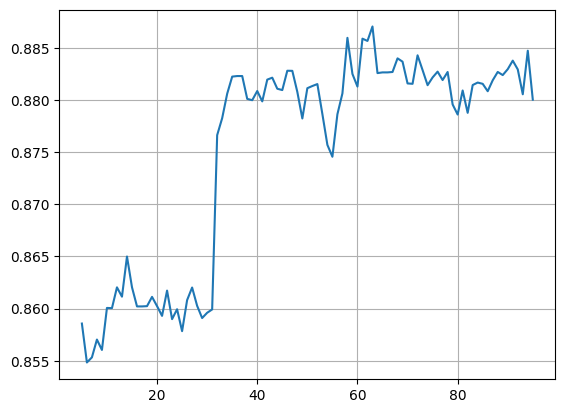

In [39]:
import matplotlib.pyplot as plt
plt.plot(cv_scores[:,0],cv_scores[:,1]) # 퍼센트를 x축 , 성능점수를 Y축
plt.grid()
plt.show()

- 최고 CV 점수의 퍼센트 값으로 피처 선택하기

In [40]:
select = SelectPercentile(percentile=best_score[0])
select.fit(train_ft,target)
best_cols = select.get_feature_names_out()
train_ft = train_ft[best_cols]
test_ft = test_ft[best_cols]

# 모델 학습및 교차 검증
- 단일 모델에 대한 K-Fold 앙상블
- cv 개수 만큼 모델을 만들어 산술평균 하는 방법

In [41]:
!pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 7.6 MB/s eta 0:00:00


In [42]:
from flaml import AutoML

In [45]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.2 MB/s eta 0:00:00


In [46]:
auto_ml = AutoML() # 객체 생성

# AutoML 클래스의 fit 메서드에 전달할 아규먼트
params = {
    "metric": "f1",
    "task": "classification",
    "time_budget": 180, # 초단위
    "seed": SEED,
    "ensemble": True,
    "early_stop":True,
    "estimator_list" : ['lgbm', 'xgboost', 'rf', 'extra_tree', 'catboost','histgb']

}
auto_ml.fit(train_ft, target, **params) # 튜닝 및 학습이 자동으로 진행 된다.

[flaml.automl.logger: 06-26 13:36:50] {1680} INFO - task = classification
[flaml.automl.logger: 06-26 13:36:50] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-26 13:36:50] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 06-26 13:36:50] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree', 'catboost', 'histgb']
[flaml.automl.logger: 06-26 13:36:50] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-26 13:36:51] {2345} INFO - Estimated sufficient time budget=670s. Estimated necessary time budget=2s.
[flaml.automl.logger: 06-26 13:36:51] {2392} INFO -  at 0.4s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 06-26 13:36:51] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-26 13:36:51] {2392} INFO -  at 0.5s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 06-26 13:36:51] {22

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(n_splits=5,shuffle=True, random_state=42)

In [49]:
scores = cross_val_score(auto_ml,train_ft,target,cv = cv ,scoring='f1',n_jobs = -1)
np.mean(scores)

KeyboardInterrupt: 

In [ ]:
ㅁㄴㅇㅁㄴㅇ

In [50]:
pred = auto_ml.predict(test_ft) # 예측
pred

array([0, 0, 0, ..., 1, 0, 0])

In [51]:
submit = pd.read_csv(f"{DATA_PATH}sample_submission.csv")
submit

,ID,target
0,test_0,NaN
1,test_1,NaN
2,test_2,NaN
3,test_3,NaN
4,test_4,NaN
...,...,...
3451,test_3451,NaN
3452,test_3452,NaN
3453,test_3453,NaN
3454,test_3454,NaN


In [52]:
submit["target"] = pred
submit

,ID,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0
...,...,...
3451,test_3451,0
3452,test_3452,0
3453,test_3453,1
3454,test_3454,0


In [53]:
submit.to_csv("submit_임태균_0626_01.csv",index=False) # 인덱스는 제외하기 위해 False

In [ ]:
pred_list = [] # fold 별 학습된 모델의 테스트 데이터에 대한 예측을 담을 리스트
for model in model_list:
    pred = model.predict_proba(test_ft)[:,1] # 1에 대한 확률을 저장하여 soft voting을 한다.
    pred_list.append(pred)

In [ ]:
pred_list

In [ ]:
pred = np.mean(pred_list,axis=0) # 산술평균
pred

In [ ]:
pred = (pred > 0.5).astype(int) # 0 또는 1 값으로 변경
pred

# 평가를 위한 제출 파일 생성
- sample_submission.csv 파일을 불러와서 예측 결과를 target 컬럼에 넣어 csv 파일로 저장후에 컴피티션 페이지에 제출한다.

In [ ]:
submit = pd.read_csv(f"{DATA_PATH}sample_submission.csv")
submit

In [ ]:
submit["target"] = pred
submit

- 예측 결과를 csv 파일로 저장하고 컴피티션 페이지에 제출하여 결과 확인하기


In [ ]:
# submit.to_csv("submit_임태균_0626_01.csv",index=False) # 인덱스는 제외하기 위해 False